<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,2,0,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,0,0,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-10-19 17:00:00+09:00,378,1336,78,0,2020-10-19 17:00:00+09:00
2020-10-20 17:00:00+09:00,328,1067,139,0,2020-10-20 17:00:00+09:00
2020-10-21 17:00:00+09:00,334,1068,150,0,2020-10-21 17:00:00+09:00
2020-10-22 17:00:00+09:00,362,1140,185,0,2020-10-22 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-10-19 17:00:00+09:00,378,1336,78,0,2020-10-19 17:00:00+09:00,361.714286,2532.0,1087.857143,7615.0,179.428571,1256.0,0.0,0.0
2020-10-20 17:00:00+09:00,328,1067,139,0,2020-10-20 17:00:00+09:00,351.857143,2463.0,1058.714286,7411.0,175.571429,1229.0,0.0,0.0
2020-10-21 17:00:00+09:00,334,1068,150,0,2020-10-21 17:00:00+09:00,343.714286,2406.0,1043.285714,7303.0,171.714286,1202.0,0.0,0.0
2020-10-22 17:00:00+09:00,362,1140,185,0,2020-10-22 17:00:00+09:00,344.857143,2414.0,1040.714286,7285.0,157.571429,1103.0,0.0,0.0
2020-10-23 17:00:00+09:00,0,0,186,0,2020-10-23 17:00:00+09:00,295.285714,2067.0,877.571429,6143.0,157.857143,1105.0,0.0,0.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-10-09 17:00:00+09:00,390,1307,203,0,2020-10-09 17:00:00+09:00,472.714286,3309.0,1354.000000,9478.0,164.142857,1149.0,0.0,0.0,'20w41,Fri
2020-10-10 17:00:00+09:00,449,951,248,0,2020-10-10 17:00:00+09:00,464.571429,3252.0,1340.714286,9385.0,170.142857,1191.0,0.0,0.0,'20w41,Sat
2020-10-11 17:00:00+09:00,455,964,146,0,2020-10-11 17:00:00+09:00,459.571429,3217.0,1320.857143,9246.0,175.571429,1229.0,0.0,0.0,'20w41,Sun
2020-10-12 17:00:00+09:00,527,2013,78,0,2020-10-12 17:00:00+09:00,452.571429,3168.0,1332.714286,9329.0,177.285714,1241.0,0.0,0.0,'20w42,Mon
2020-10-13 17:00:00+09:00,397,1271,166,0,2020-10-13 17:00:00+09:00,443.571429,3105.0,1316.428571,9215.0,175.714286,1230.0,0.0,0.0,'20w42,Tue
2020-10-14 17:00:00+09:00,391,1176,177,0,2020-10-14 17:00:00+09:00,431.571429,3021.0,1284.000000,8988.0,180.857143,1266.0,0.0,0.0,'20w42,Wed
2020-10-15 17:00:00+09:00,354,1158,284,0,2020-10-15 17:00:00+09:00,423.285714,2963.0,1262.857143,8840.0,186.000000,1302.0,0.0,0.0,'20w42,Thu
2020-10-16 17:00:00+09:00,347,1142,184,0,2020-10-16 17:00:00+09:00,417.142857,2920.0,1239.285714,8675.0,183.285714,1283.0,0.0,0.0,'20w42,Fri
2020-10-17 17:00:00+09:00,318,772,235,0,2020-10-17 17:00:00+09:00,398.428571,2789.0,1213.714286,8496.0,181.428571,1270.0,0.0,0.0,'20w42,Sat
2020-10-18 17:00:00+09:00,347,760,132,0,2020-10-18 17:00:00+09:00,383.000000,2681.0,1184.571429,8292.0,179.428571,1256.0,0.0,0.0,'20w42,Sun


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-09-27 17:00:00+09:00,149.428571,1046
2020-10-04 17:00:00+09:00,175.571429,1229
2020-10-11 17:00:00+09:00,175.571429,1229
2020-10-18 17:00:00+09:00,179.428571,1256
2020-10-23 17:00:00+09:00,147.600000,738


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-10-09 17:00:00+09:00,390,1307,203,0,2020-10-09 17:00:00+09:00,472.714286,3309.0,1354.000000,9478.0,164.142857,1149.0,0.0,0.0,'20w41,Fri,NaN,NaN
2020-10-10 17:00:00+09:00,449,951,248,0,2020-10-10 17:00:00+09:00,464.571429,3252.0,1340.714286,9385.0,170.142857,1191.0,0.0,0.0,'20w41,Sat,NaN,NaN
2020-10-11 17:00:00+09:00,455,964,146,0,2020-10-11 17:00:00+09:00,459.571429,3217.0,1320.857143,9246.0,175.571429,1229.0,0.0,0.0,'20w41,Sun,175.571429,1229.0
2020-10-12 17:00:00+09:00,527,2013,78,0,2020-10-12 17:00:00+09:00,452.571429,3168.0,1332.714286,9329.0,177.285714,1241.0,0.0,0.0,'20w42,Mon,NaN,NaN
2020-10-13 17:00:00+09:00,397,1271,166,0,2020-10-13 17:00:00+09:00,443.571429,3105.0,1316.428571,9215.0,175.714286,1230.0,0.0,0.0,'20w42,Tue,NaN,NaN
2020-10-14 17:00:00+09:00,391,1176,177,0,2020-10-14 17:00:00+09:00,431.571429,3021.0,1284.000000,8988.0,180.857143,1266.0,0.0,0.0,'20w42,Wed,NaN,NaN
2020-10-15 17:00:00+09:00,354,1158,284,0,2020-10-15 17:00:00+09:00,423.285714,2963.0,1262.857143,8840.0,186.000000,1302.0,0.0,0.0,'20w42,Thu,NaN,NaN
2020-10-16 17:00:00+09:00,347,1142,184,0,2020-10-16 17:00:00+09:00,417.142857,2920.0,1239.285714,8675.0,183.285714,1283.0,0.0,0.0,'20w42,Fri,NaN,NaN
2020-10-17 17:00:00+09:00,318,772,235,0,2020-10-17 17:00:00+09:00,398.428571,2789.0,1213.714286,8496.0,181.428571,1270.0,0.0,0.0,'20w42,Sat,NaN,NaN
2020-10-18 17:00:00+09:00,347,760,132,0,2020-10-18 17:00:00+09:00,383.000000,2681.0,1184.571429,8292.0,179.428571,1256.0,0.0,0.0,'20w42,Sun,179.428571,1256.0


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

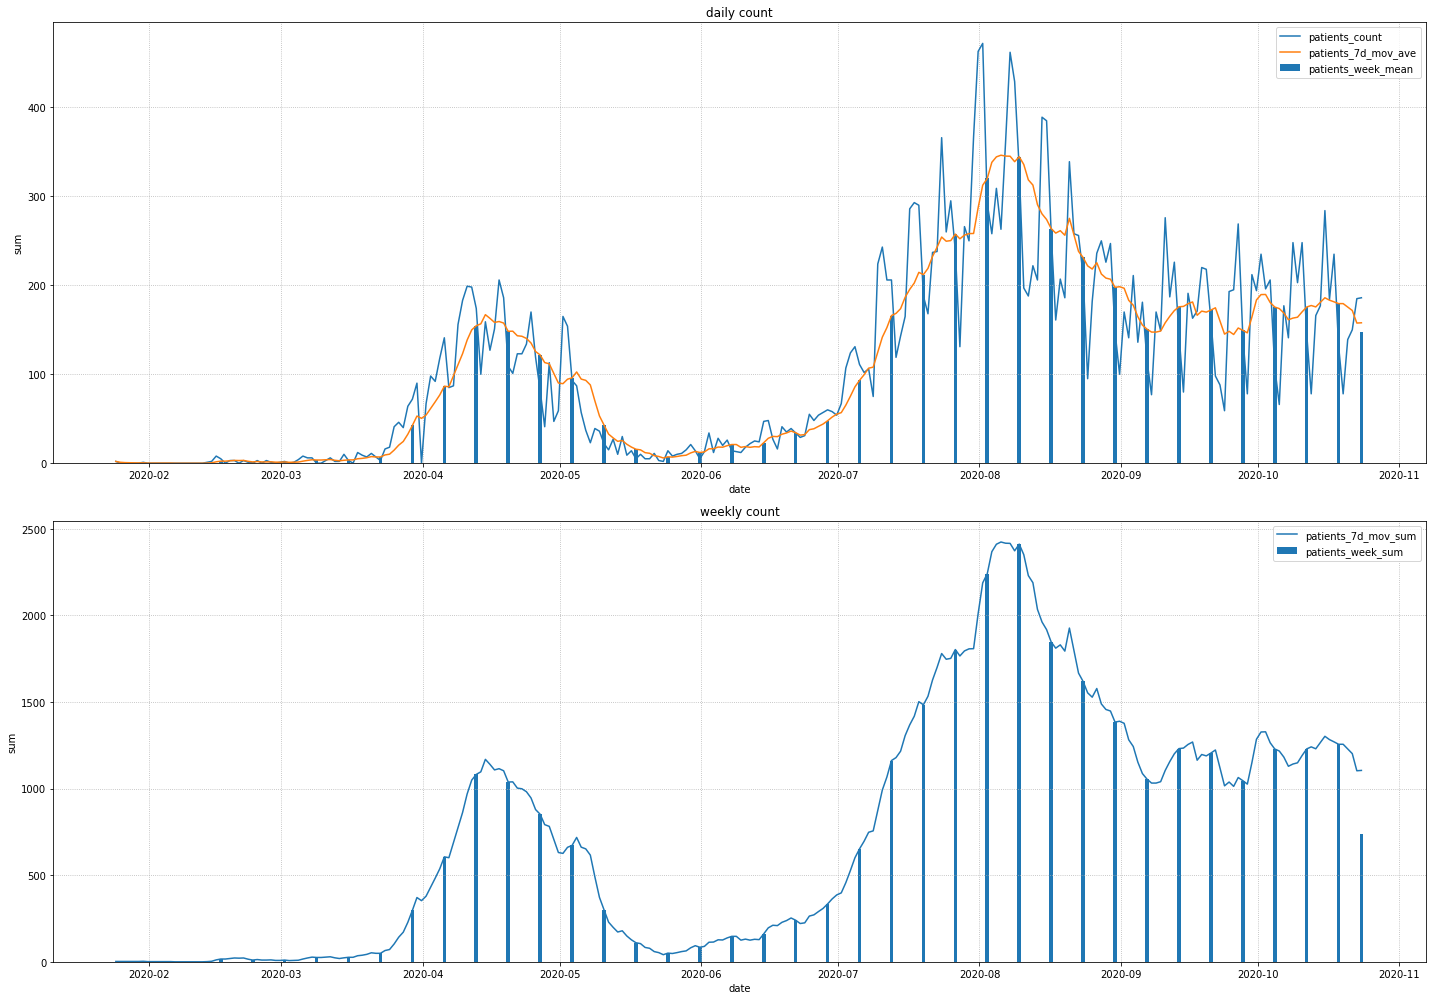

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
259,1.602230e+09,2020,10,9,1,0,0,0,0,0,0,259,0,185,390,472.714286,3309.0,1307,1354.000000,9478.0,203,164.142857,1149.0,0,0.0,0.0
260,1.602317e+09,2020,10,10,0,0,1,0,0,0,0,260,0,186,449,464.571429,3252.0,951,1340.714286,9385.0,248,170.142857,1191.0,0,0.0,0.0
261,1.602403e+09,2020,10,11,0,0,0,1,0,0,0,261,0,187,455,459.571429,3217.0,964,1320.857143,9246.0,146,175.571429,1229.0,0,0.0,0.0
262,1.602490e+09,2020,10,12,0,1,0,0,0,0,0,262,0,188,527,452.571429,3168.0,2013,1332.714286,9329.0,78,177.285714,1241.0,0,0.0,0.0
263,1.602576e+09,2020,10,13,0,0,0,0,0,1,0,263,0,189,397,443.571429,3105.0,1271,1316.428571,9215.0,166,175.714286,1230.0,0,0.0,0.0
264,1.602662e+09,2020,10,14,0,0,0,0,0,0,1,264,0,190,391,431.571429,3021.0,1176,1284.000000,8988.0,177,180.857143,1266.0,0,0.0,0.0
265,1.602749e+09,2020,10,15,0,0,0,0,1,0,0,265,0,191,354,423.285714,2963.0,1158,1262.857143,8840.0,284,186.000000,1302.0,0,0.0,0.0
266,1.602835e+09,2020,10,16,1,0,0,0,0,0,0,266,0,192,347,417.142857,2920.0,1142,1239.285714,8675.0,184,183.285714,1283.0,0,0.0,0.0
267,1.602922e+09,2020,10,17,0,0,1,0,0,0,0,267,0,193,318,398.428571,2789.0,772,1213.714286,8496.0,235,181.428571,1270.0,0,0.0,0.0
268,1.603008e+09,2020,10,18,0,0,0,1,0,0,0,268,0,194,347,383.000000,2681.0,760,1184.571429,8292.0,132,179.428571,1256.0,0,0.0,0.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              274 non-null    float64
 1   year                   274 non-null    int64  
 2   month                  274 non-null    int64  
 3   day                    274 non-null    int64  
 4   Fri                    274 non-null    uint8  
 5   Mon                    274 non-null    uint8  
 6   Sat                    274 non-null    uint8  
 7   Sun                    274 non-null    uint8  
 8   Thu                    274 non-null    uint8  
 9   Tue                    274 non-null    uint8  
 10  Wed                    274 non-null    uint8  
 11  passed                 274 non-null    int64  
 12  emergency              274 non-null    int64  
 13  em_passed              274 non-null    int64  
 14  contacts_count         274 non-null    int64  
 15  contac

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.740000e+02,274.0,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.0,274.0,274.0
mean,1.591646e+09,2020.0,5.762774,15.729927,0.145985,0.142336,0.142336,0.142336,0.142336,0.142336,0.142336,136.500000,0.178832,72.627737,800.649635,797.923271,5585.448905,1315.864964,1307.207508,9150.452555,108.416058,106.683160,746.700730,0.0,0.0,0.0
std,6.846439e+06,0.0,2.618321,8.813080,0.353738,0.350034,0.350034,0.350034,0.350034,0.350034,0.350034,79.241193,0.383913,66.338239,496.660763,482.893778,3380.279546,781.587433,598.399250,4188.794753,107.138994,98.195693,687.457868,0.0,0.0,0.0
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.585750e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.250000,0.000000,0.000000,471.000000,473.500000,3314.500000,814.750000,989.642857,6927.500000,10.250000,10.392857,72.750000,0.0,0.0,0.0
50%,1.591646e+09,2020.0,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.500000,0.000000,62.500000,651.000000,662.428571,4637.000000,1308.000000,1307.357143,9151.500000,81.000000,93.785714,656.500000,0.0,0.0,0.0
75%,1.597543e+09,2020.0,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,204.750000,0.000000,130.750000,1022.500000,1021.357143,7149.500000,1802.500000,1747.285714,12231.000000,185.750000,175.571429,1229.000000,0.0,0.0,0.0
max,1.603440e+09,2020.0,10.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,273.000000,1.000000,199.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.285714,2424.000000,0.0,0.0,0.0


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000e+00,NaN,0.993870,-0.007842,-2.817224e-18,-0.002575,-0.012876,-0.007726,0.012876,0.002575,0.007726,1.000000e+00,-0.227149,0.977608,0.064957,0.119868,0.119874,0.428629,0.617958,0.617958,0.656401,0.726587,0.726697,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.938696e-01,NaN,1.000000,-0.118191,-2.020741e-03,-0.002990,-0.010984,-0.006987,0.012997,0.001006,0.009000,9.938696e-01,-0.223656,0.970352,0.068975,0.121805,0.121811,0.429950,0.621828,0.621828,0.657182,0.725264,0.725388,NaN,NaN,NaN
day,-7.841512e-03,NaN,-0.118191,1.000000,1.856802e-02,0.004195,-0.017178,-0.005304,-0.001742,0.013694,-0.012429,-7.841512e-03,-0.001912,-0.003756,-0.017637,-0.000884,-0.000890,-0.025598,-0.056870,-0.056870,-0.046778,-0.033770,-0.033889,NaN,NaN,NaN
Fri,-2.817224e-18,NaN,-0.002021,0.018568,1.000000e+00,-0.168430,-0.168430,-0.168430,-0.168430,-0.168430,-0.168430,1.857057e-18,-0.004134,0.003729,-0.031065,-0.012378,-0.012376,0.047582,-0.013525,-0.013525,0.095913,-0.002309,-0.002441,NaN,NaN,NaN
Mon,-2.575202e-03,NaN,-0.002990,0.004195,-1.684304e-01,1.000000,-0.165957,-0.165957,-0.165957,-0.165957,-0.165957,-2.575202e-03,0.000696,-0.002915,0.054206,0.001613,0.001614,0.287306,0.001010,0.001010,-0.158743,-0.001172,-0.001147,NaN,NaN,NaN
Sat,-1.287601e-02,NaN,-0.010984,-0.017178,-1.684304e-01,-0.165957,1.000000,-0.165957,-0.165957,-0.165957,-0.165957,-1.287601e-02,0.000696,-0.011749,0.040258,-0.000632,-0.000630,-0.325257,-0.004226,-0.004226,0.112303,-0.004316,-0.004343,NaN,NaN,NaN
Sun,-7.725607e-03,NaN,-0.006987,-0.005304,-1.684304e-01,-0.165957,-0.165957,1.000000,-0.165957,-0.165957,-0.165957,-7.725607e-03,0.000696,-0.007332,-0.008899,0.000443,0.000444,-0.299055,-0.002328,-0.002328,-0.039287,-0.002342,-0.002334,NaN,NaN,NaN
Thu,1.287601e-02,NaN,0.012997,-0.001742,-1.684304e-01,-0.165957,-0.165957,-0.165957,1.000000,-0.165957,-0.165957,1.287601e-02,0.000696,0.010651,-0.006918,0.004783,0.004785,0.086470,0.009192,0.009192,0.096578,0.006021,0.006069,NaN,NaN,NaN
Tue,2.575202e-03,NaN,0.001006,0.013694,-1.684304e-01,-0.165957,-0.165957,-0.165957,-0.165957,1.000000,-0.165957,2.575202e-03,0.000696,0.001501,-0.029800,0.002628,0.002630,0.118631,0.003676,0.003676,-0.048957,0.000933,0.000969,NaN,NaN,NaN


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum', 'discharges_count',
       'discharges_7d_mov_ave', 'discharges_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          'discharges_7d_mov_ave', 'discharges_7d_mov_sum'], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,2,2.000000,2.0,0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,0,1.000000,2.0,0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0,0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0,0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,1.603094e+09,0,1,0,0,0,0,0,269,0,195,378,1336,78,179.428571,1256.0,0
270,1.603181e+09,0,0,0,0,0,1,0,270,0,196,328,1067,139,175.571429,1229.0,0
271,1.603267e+09,0,0,0,0,0,0,1,271,0,197,334,1068,150,171.714286,1202.0,0
272,1.603354e+09,0,0,0,0,1,0,0,272,0,198,362,1140,185,157.571429,1103.0,0


In [26]:
import seaborn as sns

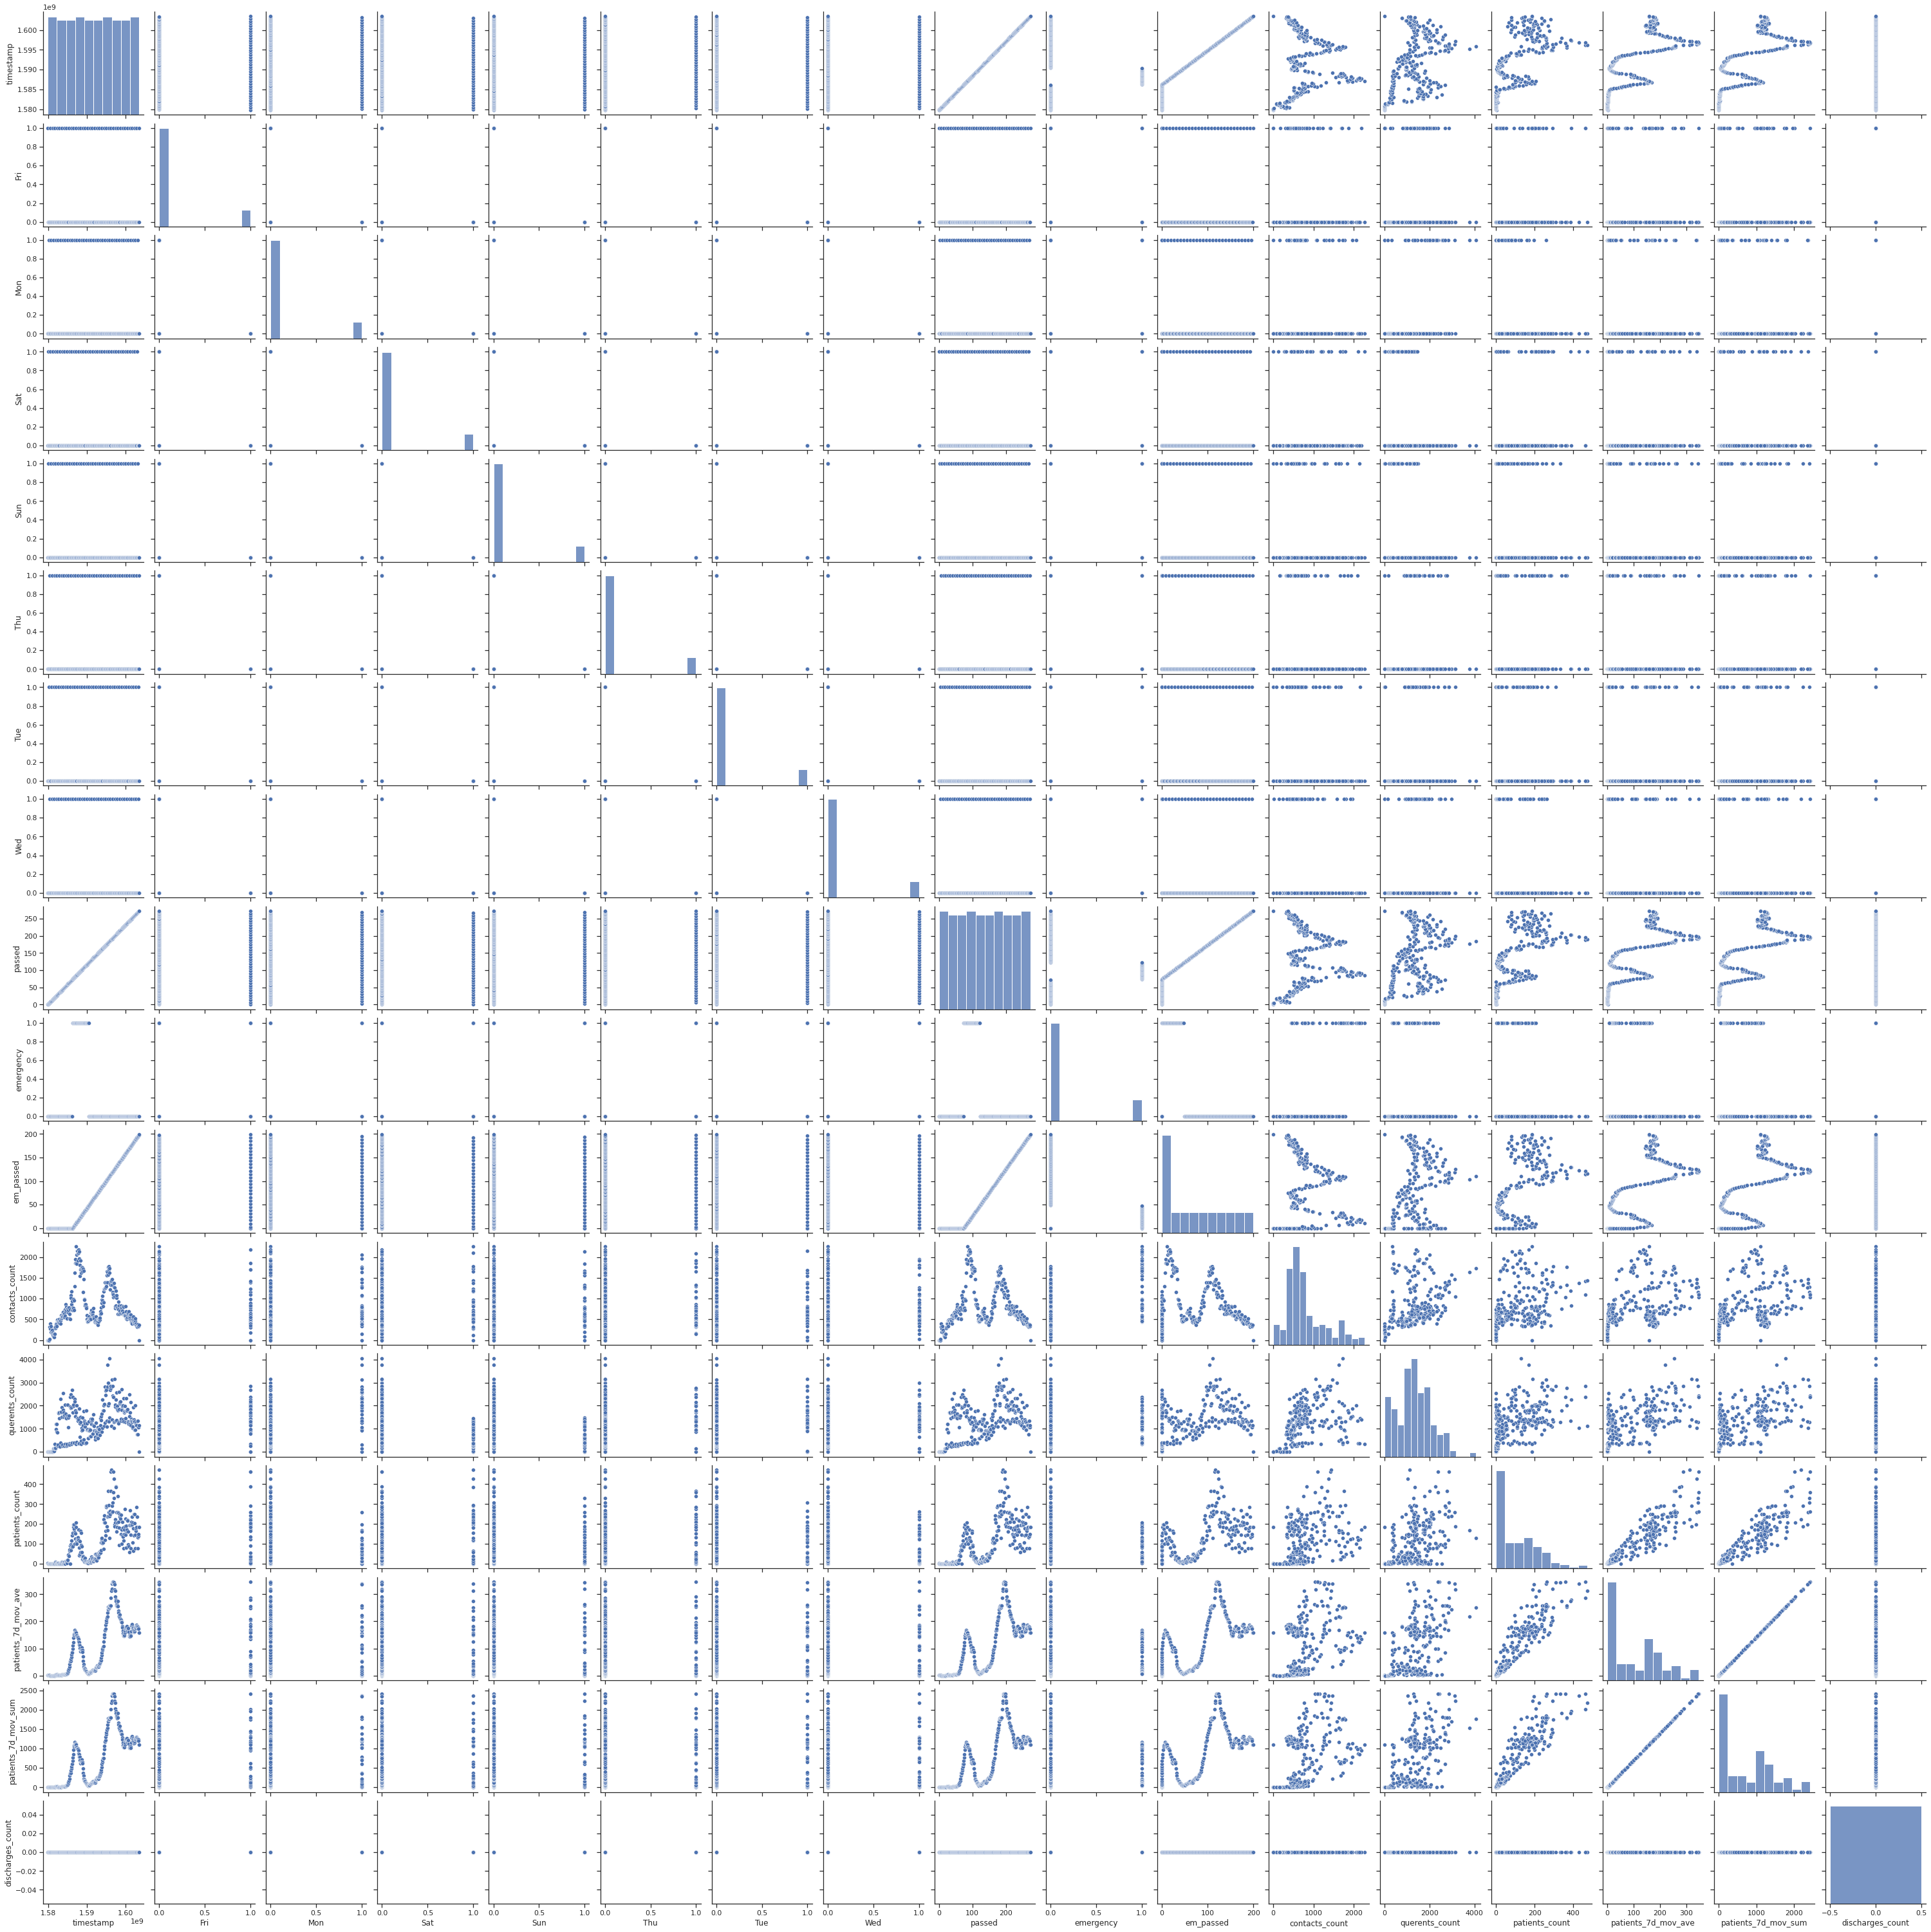

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
